In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import networkx as nx
import math 
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

import scipy.cluster.hierarchy as spc

### Miscellanous



Experiences on Independent Cascades

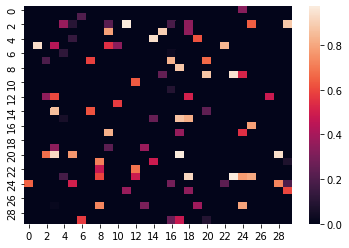

In [ ]:
"""
creates random link probability matrix
"""
nV = 30
nT = 30
pEdge = 0.1
theta_ex = np.random.uniform(0,1,(nV,nT))
mask = np.random.binomial(1,pEdge,(nV,nT))
theta_ex = theta_ex * mask
sns.heatmap(theta_ex)

In [ ]:
def createIndependentCascade(S, nb_cascade, theta):
    """creates multiple independent cascades following theta probability 
    input : 
        S seeds
    output : 
        "parents" array(nb_cascade, V) representing the DAG of each cascades
    """
    nb_V = theta.shape[0]

    parent = np.empty(shape=(nb_cascade,nb_V))
    parent[:] = np.nan
    for s in S : 
        parent[:, s] = s

    vertices = np.arange(0,nb_V)
    
    for c in range(nb_cascade):
        
        to_process = S.copy() #list assignments in python are only assigning pointers

        while len(to_process) > 0 :
            s = to_process.pop(0) #Queue
            activations = np.random.uniform(high = 1, size = nb_V) < theta[s, :]
            activated = vertices[activations]
            
            for v in activated :
                if parent[c,v] != parent[c,v] :
                    parent[c,v] = s
                    to_process.append(v)


    return parent

parents = createIndependentCascade([0, 7], 3, theta_ex)

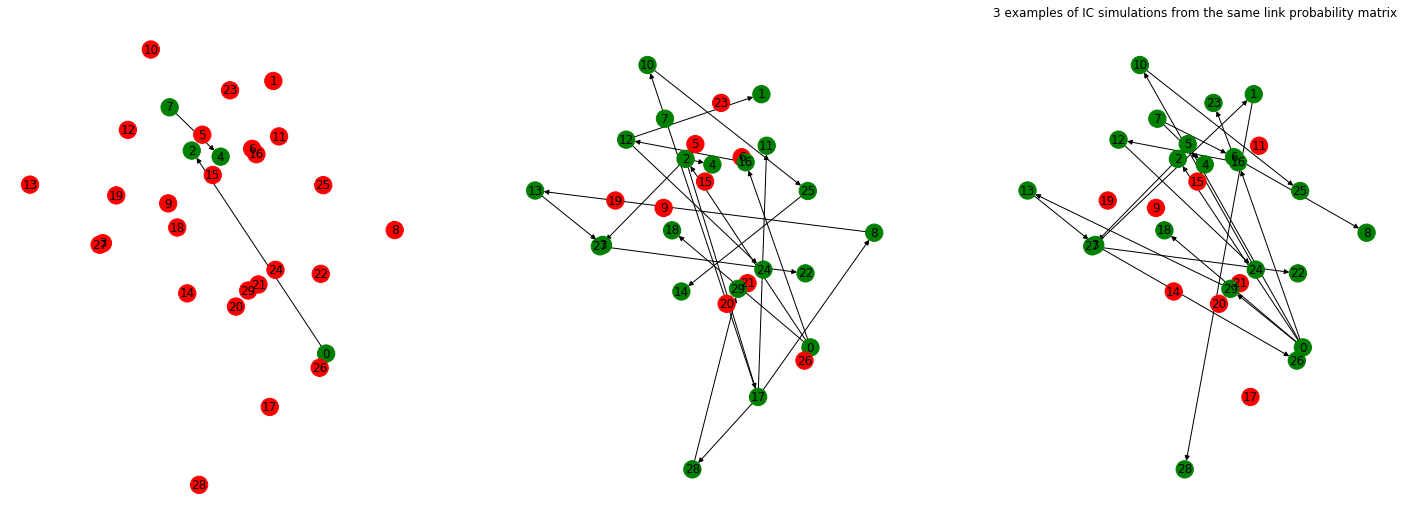

In [ ]:

def graphCascade(parents, k) :
    """Returns the DAG associated with the kth line of parents"""
    
    nbV = parents.shape[1]

    G = nx.DiGraph()
    G.add_nodes_from(list(range(nbV)))

    for i in range(nbV) :
        if parents[k, i] == parents[k, i] : 
            G.add_edge(parents[k,i], i)
    
    return G

def drawCascades(parents, nrows, ncols ) :
    fig, axes = plt.subplots(nrows, ncols, figsize = (nrows * 25, ncols * 3))
    color_map = np.vectorize(lambda x : 'red' if math.isnan(x) else 'green' )(parents)

    G = nx.DiGraph(theta_ex)
    pos = nx.kamada_kawai_layout(G)#graphviz_layout(G, prog="twopi")
    
    for k in range(0,parents.shape[0]):
        
        G = graphCascade(parents, k)
        nx.draw(G,with_labels = True, pos = pos, ax=axes[k], node_color = list(color_map[k]))

    plt.title(f"{parents.shape[0]} examples of IC simulations from the same link probability matrix ")
    plt.show()

drawCascades(parents, 1,3)

Power law graphs 

In [ ]:
def exports_graph_power_law() :
    """
    exports a dense graph with edge weights following a power law
    """
    A = np.random.uniform(0,1,(100,100))
    weights = -np.log(A)

    G = nx.DiGraph(weights)
    nx.write_gexf(G, "graphs/weighted_100.gexf")


### Twitter dataset
Loading the data : 

In [2]:
%%time
df_retweets = pd.read_csv("data/retweetsranked_full.csv", 
    sep = ';', 
    #chunksize=1000, 
    nrows=  1000000,
    header=None, 
    names=["RT", "Date", "User1", "User2", "Orig"], 
    parse_dates=["Date"], 
    dtype={"User1" : np.int32, "User2": np.int32})


df_texts = pd.read_csv("data/retweetstext.csv", 
    sep = "#1#8#3#", 
    nrows= 1000, 
    header=None, 
    names = ['RT', 'Text', "Date", "User1", "User2", "Orig"],
    parse_dates=['Date'],
    dtype={"User1" : np.int32, "User2": np.int32})

#contains 301M edges
df_graph = pd.read_csv("data/graph_twitter_full.csv", 
    nrows=1000000,
    #nrows=10, 
    header=None, 
    names = ['u', 'v'],
    dtype={"u": np.int32, "v":np.int32})


CPU times: total: 1.61 s
Wall time: 2.42 s


Distribution of number of rts : power law

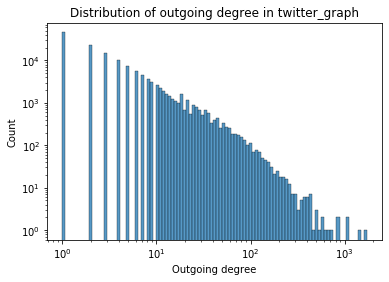

In [28]:
%%time
df_gb_User1 = df_retweets[['User1','User2']]\
    .groupby('User1')\
        .agg({'User2': [list, 'count']})\
            .reset_index()
df_gb_User1.sort_values(("User2",'count'), ascending=False)
sns.histplot(df_gb_User1[('User2','count')], log_scale=(10,10))
plt.Line2D(xdata=[1, 1000], ydata=[5000, 0])

plt.title("Distribution of outgoing degree in twitter_graph")
plt.xlabel("Outgoing degree")
plt.show()

In [7]:

def export_graph_first_k_users(k):
    """
    creates the graph containing all retweets of k first users (if k < 6900, the first 1M rows of df_retweets are enough)
    and exports it in graph/firstkuser.gexf
    """
    df = df_graph[df_graph['u'] < k]
    G=nx.DiGraph()
    for (u,v) in zip(df['u'], df['v']) :
        G.add_edge(u,v)
        G.nodes[u]['Role'] = 'Influencer'
        
    nx.write_gexf(G, f"graphs/first{k}user.gexf")
#export_graph_first_k_users(100)

In [6]:
%%time

def createStatisticsPickle() :
    """
    loads the data of statistics.txt in a pandas dataframe
    and stores it in data/statistics.pkl

    Normally runs in 20s for 8M lines 
    """
    with open('results/statistics.txt', 'r') as file :

        headers = file.readline().split()
        d = {}
        for header in headers :
            d[header] = []
        i=0
        for line in file.readlines() :
            if i%500000 == 0 :
                print(f"{i}th line. ")
            line = line.split()

            d[headers[0]].append(int(line[0]))
            d[headers[1]].append(int(line[1]))
            d[headers[2]].append(int(line[2]))
            if len(line) > 3 :
                d[headers[3]].append(line[3])
            else : 
                d[headers[3]].append('')

            i += 1
        df_stat = pd.DataFrame(d)
        df_stat.to_pickle("data/statistics.pkl")

CPU times: total: 0 ns
Wall time: 0 ns


Subsampling of RTs with tweets having more than n RTs

In [4]:
%%time
"""
df_orig : Counts the number of rts each original tweet has
"""
df_orig = df_retweets.groupby('Orig').agg({'RT' : 'count', 'User1' : list, 'User2' : 'first'})
df_orig = df_orig.sort_values('RT')


CPU times: total: 56.9 s
Wall time: 57 s


In [13]:
n_min_retweets = 5
df_orig_k = df_orig[df_orig['RT']>n_min_retweets]

list_target = list(set(df_orig_k.User1.sum()))
list_infl = list(df_orig_k.User2.unique())

print(f"""Summary : \n - {df_retweets.shape[0]} retweets processed 
- Concerning {df_orig.shape[0]} original tweets 
- Among which {df_orig_k.shape[0]} have more than {n_min_retweets} retweets
- Only considering these tweets : There are {len(list_infl)} influencers and {len(list_target)} targets 
- which represent {len(list_infl) / len(list(df_retweets.User2.unique())) * 100}% of influencers and {len(list_target) / len(list(df_retweets.User1.unique())) * 100}% of targets""")

Summary : 
 - 1000000 retweets processed 
- Concerning 846139 original tweets 
- Among which 6145 have more than 5 retweets
- Only considering these tweets : There are 1435 influencers and 38778 targets 
- which represent 0.503069248270809% of influencers and 26.96718290367671% of targets


In [14]:
df_retweets_filtered = df_retweets.merge(df_orig_k, on=['Orig', 'User2'], how='inner')
df_retweets_filtered.drop(columns=['User1_y'], inplace = True, ) # access this info in df_orig_k
df_retweets_filtered.columns = ['RT', 'Date','User1','User2','Orig', 'nRtOrig']

df_User12 = df_retweets_filtered.groupby(['User1','User2']).agg({'RT': 'count'}).reset_index()
df_User12.columns = ['User1','User2','weightEdge']

df_retweets_filtered = df_retweets_filtered.merge(df_User12, on = ['User1','User2'])

print("df_retweets_filtered : contains only the retweets with original tweet having more than n rts, the number of rt it has, the list of the rts it provoqued")
print("df_retweets_filtered : \n" + df_retweets_filtered.head(2).to_markdown())
print(f"shape : {df_retweets_filtered.shape}\n")
#df_retweets_filtered.to_pickle("data/df_retweets_filtered.pkl")


df_retweets_filtered : contains only the retweets with original tweet having more than n rts, the number of rt it has, the list of the rts it provoqued


In [77]:
def export_filtered() :
    
    """
    Export the weighted graph of users with edge weight = nb of User1's retweets of tweets of user 2
    only considers tweets with more than n_min_retweets rts
    """

    G = nx.DiGraph()
    G.add_weighted_edges_from(zip(df_User12['User1'], df_User12['User2'], df_User12['weightEdge']))
    nx.write_gexf(G, f"graphs/ssRT{n_min_retweets}.gexf")


#export_filtered()

### Weibo Dataset

#### Import user data

In [2]:
%%time
"""
creates the dataframe of user data and saves it in data/weibo/userProfile.pkl
"""

def convert_userProfile(path_input, path_output) : 
    with open(path_input, mode='r', encoding='gbk') as file : 
        lines = file.readlines()
        df = [[] for _ in range(15)]
        for i in range(len(lines)) : 
            df[i%15].append(lines[i].replace('\n',''))
        d = {}
        for i in range(14) : 
            d[df[i][0]] = df[i][1:]
    df = pd.DataFrame(d)
    df.columns = ['id', 'bi_followers_count', 'city', 'verified', 'followers_count','location','province', 'friends_count','name','gender','created_at','verified_type','statuses_count', 'description']
    print(f"Memory usage before processing : {df.memory_usage().sum()}")

    df['created_at'] = pd.to_datetime(df['created_at'])
    df  = df.astype({'id' : np.int64, 
                    'bi_followers_count' : np.int32, 
                    'city' : np.int16,
                    'followers_count' : np.int16, 
                    'province' : "category",
                    'friends_count' : np.int32,
                    'gender' : "category",
                    'verified_type' : "category",
                    'statuses_count' : np.int16})
    df = df.drop(columns=['location', 'name', 'description'])
    print(f"Memory usage after processing : {df.memory_usage().sum()}")
    pd.to_pickle(df, path_output)

#convert_userProfile("data/weibo/weibodata/userProfile/user_profile1.txt", "data/weibo/userProfile1.pkl")
#convert_userProfile("data/weibo/weibodata/userProfile/user_profile2.txt", "data/weibo/userProfile2.pkl")

CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
def concat_userProfile():
    df1 = pd.read_pickle("data/weibo/userProfile1.pkl")
    df2 = pd.read_pickle("data/weibo/userProfile2.pkl")
    df = pd.concat([df1, df2])
        
    print("userProfile : \n" + df.head(2).to_markdown())
    print(f"shape : {df.shape}\n")
    pd.to_pickle(df, "data/weibo/userProfile.pkl")
#concat_userProfile()

#### Import diffusion cascade : repost_data.txt


In [3]:
%%time
"""

creates 2 lists 
l_users : l_users[i] contains a list of influenced user_ids of ith tweet
l_times : l_times[i] contains a list of timestamps of influenced users of ith tweet

"""
NB_TWEETS = 1000
NB_RT_MAX_PER_TWEET = np.inf

with open("data/weibo/weibodata/diffusion/repost_data.txt", 'r') as file :
    
    l_users, l_times = [], []
    rts_users, rts_times = [], []
    tweet_id, rt_id = 0,0
    remaining_nb_of_rt = 0
    
    for line in file.readlines() : 

        if tweet_id > NB_TWEETS : break

        if remaining_nb_of_rt == 0 :
            tweet_id +=1
            if tweet_id % (NB_TWEETS // 10) == 0 : 
                print(f"{tweet_id / (NB_TWEETS // 100)}%")
            l_users.append(rts_users)
            l_times.append(rts_times)
                
            rts_users = []
            rts_times = []

            rt_id = 0
            remaining_nb_of_rt = int(line.replace('\n', '').split('\t')[1])
        else : 
            user  = int(line.replace('\n', '').split('\t')[1])
            time  = int(line.replace('\n', '').split('\t')[0])
            if rt_id < NB_RT_MAX_PER_TWEET : 
                rts_users.append(user)
                rts_times.append(time)
            rt_id += 1
            remaining_nb_of_rt -= 1
        
number_retweets = [len(rt) for rt in l_users]

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
CPU times: total: 6.69 s
Wall time: 9.72 s


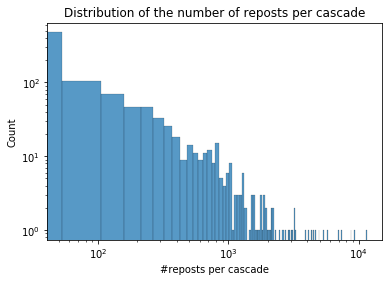

In [6]:
sns.histplot(number_retweets)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("#reposts per cascade")
plt.title('Distribution of the number of reposts per cascade')
plt.show()

In [8]:
"""
estimates the number of targets in the list l_users
"""
targets = set([users for rts in l_users for users in rts])
print(f"Only considering {NB_TWEETS} tweets : {len(targets)} targets.")

Only considering 1000 tweets : 264240 targets.


In [9]:
"""
creates a 3-tensor sets : 

sets[i,j,0] = number of retweets in ith cascade
sets[i,j,1] = number of retweets in jth cascade 
sets[i,j,2] = number of retweets in common in ith and jth cascade 
"""

lset = [set(rts) for rts in l_users]
sets = np.zeros((NB_TWEETS, NB_TWEETS, 3))

for i in range(NB_TWEETS) :
    for j in range(i+1) :
        sets[i,j,0] = number_retweets[i]
        sets[i,j,1] = number_retweets[j]
        sets[i,j,2] = len( lset[i].intersection(lset[j]) )


Community analysis : are all the cascades disjoint ?

In [10]:
"""
fusions[i] = list of all tweets <= i having at least one target in common with tweet i
"""
fusions = [list(np.arange(0, NB_TWEETS)[(sets[k,:,2] > 0)]) for k in range(NB_TWEETS)]
fusions[0] = [0]
fusions[:10]

[[0], [1], [2], [2, 3], [1, 4], [1, 2, 4, 5], [6], [7], [1, 8], [1, 9]]

In [11]:
def max_cc() :
    """
    sizes of connected component 
    """
    g = nx.Graph()
    g.add_nodes_from(list(range(NB_TWEETS)))
    for i in range(NB_TWEETS) : 
        for x in fusions[i] : 
            if x != i :
                g.add_edge(i, x)
    #nx.write_gexf(g, "graphs/communities.gexf")
    cc = sorted(nx.connected_components(g), key=len, reverse=True)
    print(f"Size of 10 largest connected components of undirected influence graph : {[len(c) for c in cc[:10]]}")

max_cc()    

Size of 10 largest connected components of undirected influence graph : [920, 2, 2, 2, 2, 2, 2, 1, 1, 1]


Time distribution of influences

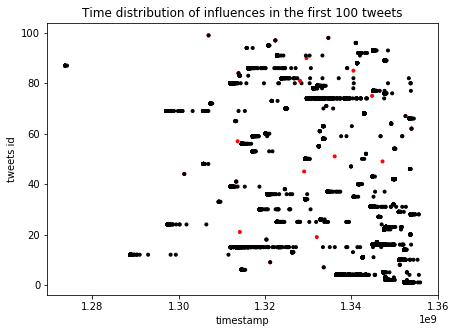

In [12]:
n_display = 100
colors = ['black']
plt.figure(figsize=(7,5))

x,y,c = [],[],[]
n_colors = len(colors)

for i in range(n_display) :
    for time in l_times[i] :
        x.append(time)
        y.append(i)
        if time == l_times[i][0] : #first influence is in red
            c.append('r')
        else : 
            c.append(colors[i%n_colors])
plt.scatter(x,y, c=c, marker='.')
plt.title(f'Time distribution of influences in the first {n_display} tweets')
plt.xlabel('timestamp')
plt.ylabel('tweets id')
plt.show()


#### Link predictions 

find the real user ids to be able to find the features 

In fact it is not possible : some original posts from repost_data.txt cannot be found in total.txt so we only focus on total.txt 

In [15]:
u_to_userids = pd.read_csv("data/weibo/weibodata/diffusion/uidlist.txt",header=None)
u_to_userids.columns = ['userid']
u_to_userids.index.name = 'uid'

cascade_to_mids = pd.read_csv("data/weibo/weibodata/diffusion/repost_idlist.txt", header=None,)
cascade_to_mids.columns = ['mid']
cascade_to_mids.index.name = 'cascade'
cascade_to_mids.mid = cascade_to_mids.mid.astype('str')

print("u_to_userids : \n" + u_to_userids.head(2).to_markdown())
print(f"shape : {u_to_userids.shape}\n")
print("cascade_to_mids : \n" + cascade_to_mids.head(2).to_markdown())
print(f"shape : {cascade_to_mids.shape}\n")

u_to_userids : 
|   uid |   userid |
|------:|---------:|
|     0 |    10029 |
|     1 |    10057 |
shape : (1787443, 1)

cascade_to_mids : 
|   cascade |              mid |
|----------:|-----------------:|
|         0 | 3509517944222416 |
|         1 | 3491370159772884 |
shape : (300000, 1)



In [16]:
roots = []                      #cascades informations : mid - date - u - likes
users = []                      #users[i] = list of influenced nodes of cascade i
times = []                      #times[i][j] = time of influence of users[i][j]
NB_CASCADES = 1000

with open("data/weibo/weibodata/total.txt", 'r') as file :
    count_line = 0 

    for line in file.readlines() :
    
        if count_line > 2 * NB_CASCADES - 1: break
    
        if count_line%2 == 0 : #mid - date - user1 - #likes
            roots.append(line.replace('\n', '').split())

        else : 
            users_curr, times_curr = [], []
            c = 0
            for x in line.replace('\n', '').split() :
                if c%2 == 0 :
                    users_curr.append(x)
                else :
                    times_curr.append(x)
                c += 1
            users.append(users_curr)
            times.append(times_curr)

        count_line+= 1
    
infos_cascades = pd.DataFrame(roots, columns = ['mid', 'date', 'User1', '#likes?'])
infos_cascades['#reposts'] = pd.Series(infos_cascades.index).apply(lambda i : len(users[i]))

del(roots)


print("infos_cascades : \n" + infos_cascades.head(5).to_markdown())
print(f"shape : {infos_cascades.shape}\n")

infos_cascades : 
|    |              mid | date                |   User1 |   #likes? |   #reposts |
|---:|-----------------:|:--------------------|--------:|----------:|-----------:|
|  0 | 3479380645050771 | 2012-08-15-20:07:32 | 1500872 |         3 |          2 |
|  1 | 3464585309142627 | 2012-07-06-00:16:10 |  153602 |       595 |         17 |
|  2 | 3463921564867182 | 2012-07-04-04:18:39 |  519514 |      3167 |        103 |
|  3 | 3453196284937865 | 2012-06-04-14:00:14 |  490872 |      3255 |        145 |
|  4 | 3514161490841646 | 2012-11-19-19:34:09 | 1501242 |        17 |          4 |
shape : (1000, 5)



In [17]:
def empty_list(): return []
users_gb_cascades = defaultdict(empty_list)

for users2 in users :
    for user in users2 :
        users_gb_cascades[user].append(users.index(users2))

edges = []

for user in users_gb_cascades.keys() :
    for cascade in users_gb_cascades[user] :
        edges.append((infos_cascades.iloc[cascade]['User1'], user, len(users_gb_cascades[user])))


edges= pd.DataFrame(edges, columns = ['u1', 'u2', 'Av'])
del(users_gb_cascades)

print("edges : \n" + edges.head(5).to_markdown())
print(f"shape : {edges.shape}\n")

edges : 
|    |      u1 |      u2 |   Av |
|---:|--------:|--------:|-----:|
|  0 | 1500872 | 1500872 |    2 |
|  1 | 1500872 | 1500872 |    2 |
|  2 |  153602 | 1598909 |    1 |
|  3 |  153602 | 1727898 |    1 |
|  4 |  153602 | 1460582 |    1 |
shape : (157983, 3)



In [23]:
Au_table = infos_cascades.groupby('User1').agg({"#reposts" : 'sum'})
Au_table.columns = ['Au']
print("Au_table : \n" + Au_table.head(2).to_markdown())
print(f"shape : {Au_table.shape}\n")

Au_table : 
|   User1 |   Au |
|--------:|-----:|
| 1007181 |   66 |
| 1008053 |    2 |
shape : (826, 1)



In [26]:
influences = edges.merge(Au_table, left_on ='u1',  right_on='User1')
del(edges)

influences['BT'] = 1 / influences['Au']
influences['JI'] = 1 / (influences['Au'] + influences['Av'])
influences['LP'] = 1 / influences['Av']

influences.u1 = influences.u1.astype(np.int32)
influences.u2 = influences.u2.astype(np.int32)

influences = influences.merge(u_to_userids, left_on='u1', right_on = 'uid', how = 'left')
influences = influences.merge(u_to_userids, left_on='u2', right_on = 'uid', how = 'left')
influences['u'] = influences['userid_x']
influences['v'] = influences['userid_y']

influences = influences.drop(columns = ['u1', 'u2', 'Av', 'Au', 'userid_x', 'userid_y'])
influences = influences[['u', 'v', 'BT', 'JI', 'LP']]
print("influences : \n" + influences.head(5).to_markdown())
print(f"shape : {influences.shape}\n")

#pd.to_pickle(influences, f"data/weibo/labels_{NB_CASCADES}.pkl")


influences : 
|    |           u |           v |         BT |        JI |   LP |
|---:|------------:|------------:|-----------:|----------:|-----:|
|  0 | 1.67892e+09 | 1.67892e+09 | 0.5        | 0.25      |  0.5 |
|  1 | 1.67892e+09 | 1.67892e+09 | 0.5        | 0.25      |  0.5 |
|  2 | 2.30505e+09 | 1.8462e+09  | 0.00145773 | 0.0014556 |  1   |
|  3 | 2.30505e+09 | 2.17002e+09 | 0.00145773 | 0.0014556 |  1   |
|  4 | 2.30505e+09 | 1.4391e+09  | 0.00145773 | 0.0014556 |  1   |
shape : (158048, 5)



#### Topic

In [74]:
def create_topic_file():
    path_topic = 'data/weibo/weibodata/topic-100/doc'
    d = {'mid' : []}
    for i in range(N_TOPICS) :
        d[str(i)] = []

    with open(path_topic, 'r') as file : 
        i = 0
        for line in file :
            line = line.split('\t')
            if len(line) < 2 : continue
            
            d['mid'].append(int(line[1]))
            for t in range(100) :
                d[str(line[2*t+2])].append(float(line[2*t+3]))

            i += 1
        df_topic = pd.DataFrame(d)
        del(d)
    #df_topic.to_pickle("data/weibo/topic.pkl")
    print("df_topics : \n")
    print(f"shape : {df_topic.shape}\n")

df_topic = pd.read_pickle("data/weibo/topic.pkl")


Clustering 

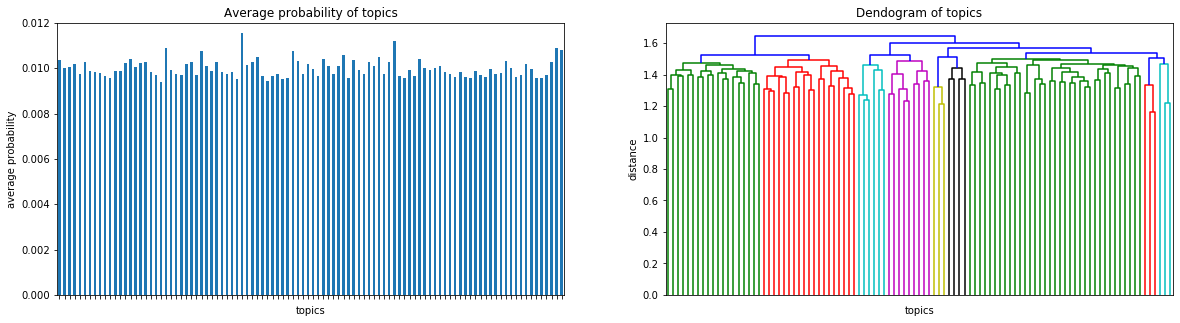

In [121]:
df_topic_sample = df_topic.sample(n = 10000)

fig, ax = plt.subplots(1,2, figsize = (20, 5))
corr = df_topic_sample.corr().values
N_TOPICS = 8

pdist = spc.distance.pdist(corr, metric='euclidean')
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, N_TOPICS, 'maxclust')

df_topic_sample.drop(columns='mid').mean().plot.bar(ax=ax[0])
ax[0].set_title("Average probability of topics")
ax[0].set_ylim(0,0.012)
ax[0].set_xlabel('topics')
ax[0].set_xticklabels([])
ax[0].set_ylabel('average probability')

dn = spc.dendrogram(linkage, ax=ax[1], color_threshold=1.5)
ax[1].set_title(f"Dendogram of topics")
ax[1].set_xlabel('topics')
ax[1].set_xticklabels([])
ax[1].set_ylabel(f"distance")

plt.show()

Text(0.5, 0.98, 'Correlation matrix between topics')

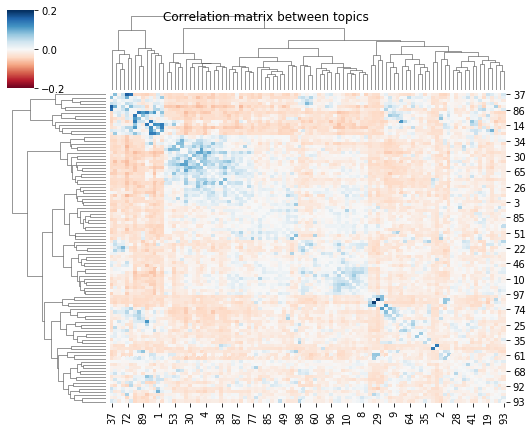

In [143]:
sns.clustermap(corr - np.identity(101), method="complete", cmap='RdBu', 
               annot_kws={"size": 7}, vmin=-0.2, vmax=0.2, figsize=(7.5,6))

plt.suptitle("Correlation matrix between topics")

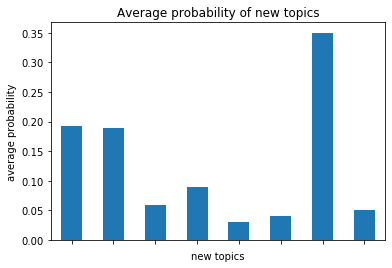

In [145]:
def convert_new_topic(df_topic, idx) : 
    """
    input : df_topic, idx st idx[i] is the new topic of i
    output : df with N_TOPICS columns 
    """
    df_new = pd.DataFrame(np.zeros((df_topic.shape[0], N_TOPICS + 1)), columns=['mid'] + list(range(N_TOPICS)))
    df_new['mid'] = df_topic['mid']
    for i in range(100) : 
        new_i = idx[i] -1
        df_new[new_i] += df_topic[str(i)]
    return df_new

df_new_topic = convert_new_topic(df_topic, idx)

fig, ax = plt.subplots(1,1)
df_new_topic.drop(columns='mid').mean().plot.bar(ax=ax)
ax.set_title("Average probability of new topics")
ax.set_xlabel('new topics')
ax.set_xticklabels([])
ax.set_ylabel('average probability')
plt.show()


In [146]:
#df_new_topic.to_pickle(f"data/weibo/topics_{N_TOPICS}.pkl")

Best examples of topics

In [56]:
with open('data/weibo/weibodata/root_content.txt', 'r', encoding='gb18030' ) as file :
    i = 0
    d_content_roots = {}
    mid = ''
    for l in file : 
        if i % 2 == 0:
            mid = l.replace('\n', '').replace('\t', '')
        else : 
            d_content_roots[mid] = l.replace('\n', '').replace('\t', '')
        i += 1


In [150]:
def best_examples_topic(topic, k) : 
    """
    Returns the first k messages having the highest probability of being in topic 
    format : 
        mid probability
        content
    """
    mids = df_topic[['mid', str(topic)]].sort_values(by = str(topic), ascending=False)[:k]
    s = ""
    for i in range(k) : 
        s_k = f"{mids.iloc[i, 0]} {mids.iloc[i, 1]} \n{d_content_roots[str(mids.iloc[i,0])]} \n"
        #print(s_k)
        s += s_k
    return s

with open("data/weibo/best_3_examples_topic.txt", 'w') as file : 
    for topic in range(100) : 
        file.write(f"{topic}\n")
        file.write(best_examples_topic(topic, 3))
        if topic % 10 == 0 : 
            print(f"{topic}%")
print(f"End")



0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
End


In [152]:
print("The 3 best examples of 2nd topics are : ")
print(best_examples_topic(2, 3))

The 3 best examples of 2nd topics are : 
3494894062682607 0.5550847457627118 
屌丝眼中的北京国庆：女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人女人 
3502750966619263 0.4375 
知人不必言尽，留些口德；责人不必苛尽，留些肚量；才能不必傲尽，留些内涵；锋芒不必露尽，留些深敛；有功不必邀尽，留些谦让；得理不必争尽，留些宽容；得宠不必恃尽，留些后路；气势不必倚尽，留些厚道；富贵不必享尽，留些福泽；凡事不必做尽，留些余德。 
5607187399018544091 0.42473118279569894 
【人生十点需牢记】1.知人不必言尽，留些口德；2.责人不必苛尽，留些肚量；3.才能不必傲尽，留些内涵；4.锋芒不必露尽，留些深敛；5.有功不必邀尽，留些谦让；6.得理不必争尽，留些宽容；7.得宠不必恃尽，留些后路；8.气势不必倚尽，留些厚道；9.富贵不必享尽，留些福泽；10.凡事不必做尽，留些余德。 



### Extract graph topology

In [21]:
users_topology = []                      

with open("data/weibo/weibodata/total.txt", 'r') as file :
    count_line = 0 

    for line in file.readlines() :
    
        if count_line > 2 * NB_CASCADES - 1: break
    
        if count_line%2 == 0 : #mid - date - user1 - #likes
            users_topology.append(line.replace('\n', '').split()[2]) #adds influencer
            
        else :  
            c = 0
            for x in line.replace('\n', '').split() :
                if c%2 == 0 :
                    users_topology.append(x) #adds targets
                c += 1
        count_line+= 1
users_topology = list(set(users_topology))
users_topology = [int(user) for user in users_topology]
users_topology = sorted(users_topology)

print(f"users_topology : \n {users_topology[-10:]} ..." )
print(f"length : {len(users_topology)}\n")

users_topology : 
 [1786781, 1786882, 1786893, 1786911, 1786944, 1786996, 1787088, 1787161, 1787223, 1787427]
length : 134291



In [70]:
    
def create_edges(users_topology) : 
    """
    Creates weibo/edges_NB_CASCADES.pkl ---> |id|u|v|
    2.4M edges for 1000 cascades
    Takes 4min to extract
    """
    
    #Speeds up operation (v in users)
    def f() : return False
    d_users = defaultdict(f)
    for user in users_topology:
        d_users[user] = True

    edges_topology = []                 

    with open("data/weibo/weibodata/graph_170w_1month.txt", 'r') as file :
        
        u_previous = -1
        u_in_table = False

        n_lines = 0
        
        for line in file :
            
            n_lines += 1
            if n_lines % 17000000 == 0 :
                print(f"{n_lines} lines processed : {len(edges_topology)} edges added")

            line = line.split(' ')
            if len(line) >= 2 :
                u,v = int(line[0]), int(line[1])

                if u != u_previous : 
                    u_previous = u
                    u_in_table = (d_users[u])

                if u_in_table: 
                    if d_users[v] : 
                        edges_topology.append((u,v))
             
    return edges_topology

def process_edges(edges_topology):
    """
    replaces user id with the real ones 
    """
    df_edges = pd.DataFrame(edges_topology, columns=['u','v'])
    df_edges = df_edges.merge(u_to_userids, how='inner', left_on='u', right_on='uid')\
                        .merge(u_to_userids, how='inner', left_on='v', right_on='uid')\
                        .drop(columns = ['u','v'])
    df_edges = df_edges.rename(columns = { 'userid_y' : 'u', 'userid_x' : 'v'})
    #df_edges.to_pickle("data/weibo/edges_1000.pkl")
    
    return df_edges

#edges_topology = create_edges(users_topology)
#df_edges = process_edges(edges_topology)

end